In [0]:
!pip install xgboost seaborn --quiet

In [0]:
import numpy as np
import pandas as pd
import scipy
import io
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RepeatedKFold
import seaborn as sns

pd.options.mode.chained_assignment = None

In [0]:
#  from google.colab import files
#  uploaded = files.upload()

#### Read train data

In [0]:
df = pd.read_csv('./train_file.csv', sep = ',')
# df = pd.read_csv(io.BytesIO(uploaded['train_file.csv']))

In [0]:
df.head()

,Application/Permit Number,Permit Type,Address,Description,Action Type,Work Type,Applicant Name,Application Date,Issue Date,Final Date,Expiration Date,Status,Contractor,Permit and Complaint Status URL,Master Use Permit,Latitude,Longitude,Location,Category
0,6640280,Construction,1924 10TH AVE E,"Alterations to single family residence, (porti...",ADD/ALT,No plan review,"ZHANG, JERRY",2018-01-16T00:00:00,2018-01-16T00:00:00,NaN,2019-07-16T00:00:00,Permit Issued,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.636732,-122.319828,"{'latitude': '47.63673222', 'human_address': '...",SINGLE FAMILY / DUPLEX
1,6452959,Construction,9434 DELRIDGE WAY SW,Change use permit from restaurant to residenti...,ADD/ALT,Plan Review,"MARTIN, TERRY",2015-02-13T00:00:00,2015-04-16T00:00:00,2016-11-15T00:00:00,2016-10-16T00:00:00,Permit Closed,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.518298,-122.355555,"{'latitude': '47.51829831', 'human_address': '...",COMMERCIAL
2,6435127,Construction,535 TERRY AVE N,Construct interior alterations to existing off...,ADD/ALT,No plan review,"ALLEXSAHT, REBECCA",2014-09-04T00:00:00,2014-09-04T00:00:00,2015-11-20T00:00:00,2016-03-04T00:00:00,Permit Closed,IA/INTERIOR ARCHITECTS,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.624025,-122.337567,"{'latitude': '47.62402492', 'human_address': '...",COMMERCIAL
3,6620870,Demolition,830 4TH AVE S,need to remove a fire escape that is not part ...,DEMOLITION,Plan Review,"JUNK, FRANK",NaN,NaN,NaN,NaN,Initial Information Collected,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.595020,-122.328530,"{'latitude': '47.59502036', 'human_address': '...",COMMERCIAL
4,6363778,Construction,805 NE 106TH ST,"Channel modification to Thornton Creek, stream...",ADD/ALT,Plan Review,"DANIEL, MARK",2013-05-02T00:00:00,2013-12-19T00:00:00,2015-05-14T00:00:00,2015-06-19T00:00:00,Permit Closed,SEATTLE PARKS DEPT,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.705686,-122.320134,"{'latitude': '47.70568601', 'human_address': '...",COMMERCIAL


In [0]:
print("Info about Data:")
print("Number of rows: ", df.shape[0])
print("Number of Columns: ", df.shape[1])
print("\nNumber of null values in each column:\n", df.isnull().sum())

Info about Data:
Number of rows:  33539
Number of Columns:  19

Number of null values in each column:
 Application/Permit Number              0
Permit Type                            0
Address                               19
Description                           10
Action Type                          779
Work Type                              0
Applicant Name                       135
Application Date                    6939
Issue Date                         10624
Final Date                         17851
Expiration Date                    10569
Status                              1574
Contractor                         27503
Permit and Complaint Status URL        0
Master Use Permit                  29041
Latitude                              21
Longitude                             21
Location                               8
Category                               0
dtype: int64


In [0]:
y_train = df['Category']
df = df.drop('Category' , axis = 1)

#### Read Test Data

In [0]:
test_df = pd.read_csv('./test_file.csv', sep = ',')

In [0]:
print("Info about Data:")
print("Number of rows: ", test_df.shape[0])
print("Number of Columns: ", test_df.shape[1])

Info about Data:
Number of rows:  22360
Number of Columns:  18


#### Merge train and test data set

In [0]:
train_test = pd.concat([df, test_df], join = 'inner')
train_test.head()

,Application/Permit Number,Permit Type,Address,Description,Action Type,Work Type,Applicant Name,Application Date,Issue Date,Final Date,Expiration Date,Status,Contractor,Permit and Complaint Status URL,Master Use Permit,Latitude,Longitude,Location
0,6640280,Construction,1924 10TH AVE E,"Alterations to single family residence, (porti...",ADD/ALT,No plan review,"ZHANG, JERRY",2018-01-16T00:00:00,2018-01-16T00:00:00,NaN,2019-07-16T00:00:00,Permit Issued,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.636732,-122.319828,"{'latitude': '47.63673222', 'human_address': '..."
1,6452959,Construction,9434 DELRIDGE WAY SW,Change use permit from restaurant to residenti...,ADD/ALT,Plan Review,"MARTIN, TERRY",2015-02-13T00:00:00,2015-04-16T00:00:00,2016-11-15T00:00:00,2016-10-16T00:00:00,Permit Closed,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.518298,-122.355555,"{'latitude': '47.51829831', 'human_address': '..."
2,6435127,Construction,535 TERRY AVE N,Construct interior alterations to existing off...,ADD/ALT,No plan review,"ALLEXSAHT, REBECCA",2014-09-04T00:00:00,2014-09-04T00:00:00,2015-11-20T00:00:00,2016-03-04T00:00:00,Permit Closed,IA/INTERIOR ARCHITECTS,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.624025,-122.337567,"{'latitude': '47.62402492', 'human_address': '..."
3,6620870,Demolition,830 4TH AVE S,need to remove a fire escape that is not part ...,DEMOLITION,Plan Review,"JUNK, FRANK",NaN,NaN,NaN,NaN,Initial Information Collected,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.595020,-122.328530,"{'latitude': '47.59502036', 'human_address': '..."
4,6363778,Construction,805 NE 106TH ST,"Channel modification to Thornton Creek, stream...",ADD/ALT,Plan Review,"DANIEL, MARK",2013-05-02T00:00:00,2013-12-19T00:00:00,2015-05-14T00:00:00,2015-06-19T00:00:00,Permit Closed,SEATTLE PARKS DEPT,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.705686,-122.320134,"{'latitude': '47.70568601', 'human_address': '..."


In [0]:
print("Info about Data:")
print("Number of rows: ", train_test.shape[0])
print("Number of Columns: ", train_test.shape[1])
print("\n Number of null values in both train and test data: \n", train_test.isnull().sum())

Info about Data:
Number of rows:  55899
Number of Columns:  18

 Number of null values in both train and test data: 
 Application/Permit Number              0
Permit Type                            0
Address                               35
Description                           21
Action Type                         1259
Work Type                              0
Applicant Name                       220
Application Date                   11436
Issue Date                         17565
Final Date                         29812
Expiration Date                    17484
Status                              2609
Contractor                         45748
Permit and Complaint Status URL        0
Master Use Permit                  48395
Latitude                              37
Longitude                             37
Location                              14
dtype: int64


## Data clean

#### Drop columns which we are sparse, redundant or if you think they dont help in predicting Target category

In [0]:
del_columns = ['Master Use Permit', 'Applicant Name', 'Permit and Complaint Status URL', 
                'Location', 'Issue Date', 'Final Date']
train_test.drop(del_columns, axis = 1, inplace = True)

#### check number of unique values and categories in categorical columns

In [0]:
train_test.nunique()

Application/Permit Number    55899
Permit Type                      3
Address                      33914
Description                  47926
Action Type                     16
Work Type                        2
Application Date              2557
Expiration Date               1700
Status                          12
Contractor                    2235
Latitude                     32719
Longitude                    38129
dtype: int64

In [0]:
binary_cols =  train_test.nunique()[train_test.nunique().values == 2].keys().tolist()

# Maximum categories are for Action type. Hence threshold for categorical columns has been kept at 20
categorical_cols = train_test.nunique()[train_test.nunique().values <= 20].keys().tolist()
categorical_cols = [col for col in categorical_cols if col not in binary_cols]

date_cols = ['Application Date',  'Expiration Date']

location_cols = ['Latitude', 'Longitude' ]

text_cols = ['Address', 'Description', 'Contractor' ]

print("Binary columns are: ", binary_cols)
print("Categorical columns are: ", categorical_cols)
print("Date columns are: ", date_cols)
print("Location columns are: ", location_cols)
print("Text columns are: ", text_cols)

Binary columns are:  ['Work Type']
Categorical columns are:  ['Permit Type', 'Action Type', 'Status']
Date columns are:  ['Application Date', 'Expiration Date']
Location columns are:  ['Latitude', 'Longitude']
Text columns are:  ['Address', 'Description', 'Contractor']


#### convert date_cols to Datetime

In [0]:
for col in date_cols:
  train_test[col] = pd.to_datetime(train_test[col])

#### Remove or replace NaN values

In [0]:
for col in categorical_cols + text_cols:
    train_test[col].fillna('NA', inplace = True)
   
for col in location_cols:
    train_test[col].fillna(train_test[col].mean(), inplace = True)


In [0]:
train_test.isnull().sum()

Application/Permit Number        0
Permit Type                      0
Address                          0
Description                      0
Action Type                      0
Work Type                        0
Application Date             11436
Expiration Date              17484
Status                           0
Contractor                       0
Latitude                         0
Longitude                        0
dtype: int64

In [0]:
for col in categorical_cols:
    print("\n{}: {} \n {}".format(col, train_test[col].nunique(), train_test[col].unique()))


Permit Type: 3 
 ['Construction' 'Demolition' 'Site Development']

Action Type: 17 
 ['ADD/ALT' 'DEMOLITION' 'ALTER' 'NEW' 'TREE/VEGETATION MAINT/RESTORE'
 'NO CONSTRUCTION' 'NA' 'TEMP' 'CURB CUT' 'GRADING'
 'SHORELINE EXEMPTION ONLY' 'SITE MONITORING ONLY' 'DECONSTRUCTION'
 'RELOCATION' 'FLOODPLAIN LICENSE ONLY' 'TREE PROTECTION EXEMPTION'
 'DRAINAGE APPROVAL']

Status: 13 
 ['Permit Issued' 'Permit Closed' 'Initial Information Collected'
 'Permit Finaled' 'AP Closed' 'CANCELLED' 'Application Accepted' 'NA'
 'Reviews Completed' 'Information Collected'
 'Cert of Occupancy Authorized' 'AP Finaled' 'Inspections Added']


#### Before one hot encoding, create a train copy to be used for visualisation 

In [0]:
df_copy = train_test[:len(y_train)]
df_copy['Category'] = y_train

#### one hot encode categorical and binary columns in train and test data

In [0]:
train_test = pd.get_dummies(train_test, columns = categorical_cols)

le_bin = LabelEncoder()
for col in binary_cols:
    train_test[col] = le_bin.fit_transform(train_test[col])

## Visualisation

In [0]:
df_copy.head()

,Application/Permit Number,Permit Type,Address,Description,Action Type,Work Type,Application Date,Expiration Date,Status,Contractor,Latitude,Longitude,Category
0,6640280,Construction,1924 10TH AVE E,"Alterations to single family residence, (porti...",ADD/ALT,No plan review,2018-01-16,2019-07-16,Permit Issued,NA,47.636732,-122.319828,SINGLE FAMILY / DUPLEX
1,6452959,Construction,9434 DELRIDGE WAY SW,Change use permit from restaurant to residenti...,ADD/ALT,Plan Review,2015-02-13,2016-10-16,Permit Closed,NA,47.518298,-122.355555,COMMERCIAL
2,6435127,Construction,535 TERRY AVE N,Construct interior alterations to existing off...,ADD/ALT,No plan review,2014-09-04,2016-03-04,Permit Closed,IA/INTERIOR ARCHITECTS,47.624025,-122.337567,COMMERCIAL
3,6620870,Demolition,830 4TH AVE S,need to remove a fire escape that is not part ...,DEMOLITION,Plan Review,NaT,NaT,Initial Information Collected,NA,47.595020,-122.328530,COMMERCIAL
4,6363778,Construction,805 NE 106TH ST,"Channel modification to Thornton Creek, stream...",ADD/ALT,Plan Review,2013-05-02,2015-06-19,Permit Closed,SEATTLE PARKS DEPT,47.705686,-122.320134,COMMERCIAL


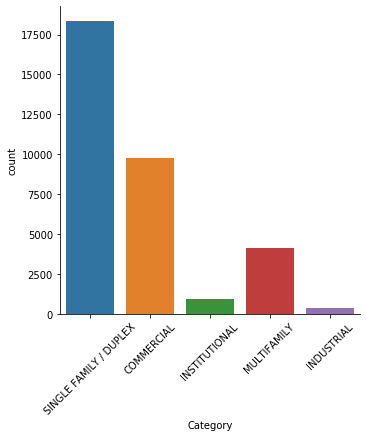

In [0]:
catplot = sns.catplot(x="Category", kind="count", data=df_copy)
catplot.set_xticklabels(rotation=45)
catplot.set_titles('Category' )
catplot.savefig('./category.png')

##### As we see above, we have an imbalanced Dataset

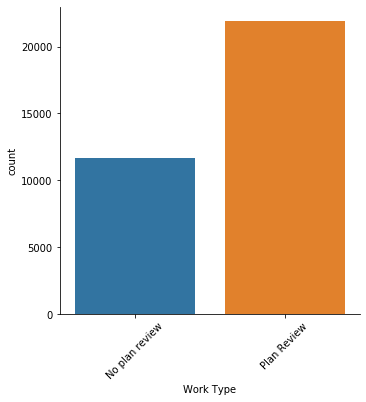

In [0]:
work_plot = sns.catplot(x="Work Type", kind="count", data=df_copy)
work_plot.set_xticklabels(rotation=45)
work_plot.set_titles('Work Type' )

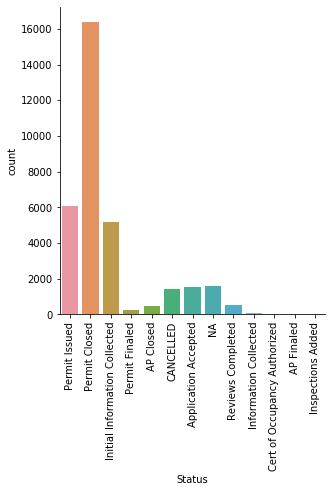

In [0]:
 status_plot = sns.catplot(x="Status", kind="count", data=df_copy)
status_plot.set_xticklabels(rotation=90)
status_plot.set_titles('Status' )

## Copy clean train data back from train_test dataframe

In [0]:
df = train_test[:len(y_train)]
df['Category'] = y_train

#### create a date dataframe to understand the time difference between expiration and application date based on Category

In [0]:
#drop rows in which Application or Expiration Date is empty
date_df = df.dropna(subset=date_cols, how='any')

In [0]:
date_df['total period'] = (date_df['Expiration Date'] - date_df['Application Date']).dt.days

#### We see that different categories have time periods for Expiration Date with Multi family Categories having longest duration

In [0]:
diff = date_df.groupby(['Category'])['total period'].mean()
diff

Category
COMMERCIAL                649.047861
INDUSTRIAL                718.448980
INSTITUTIONAL             695.557070
MULTIFAMILY               753.878155
SINGLE FAMILY / DUPLEX    655.072607
Name: total period, dtype: float64

#### We will use the above data for imputing NaN date values in train data based on categories

In [0]:
# Mean time  for Total period across all Categories. We use this to append NaN values in test data
diff.mean()

694.4009342795456

#### Finding time difference in days for train data

#### Fill NaN values in total period column with mean value based on Category

In [0]:
df['total period'] = (df['Expiration Date'] - df['Application Date']).dt.days

In [0]:
df['total period'] = df.apply(
    lambda row: diff[row['Category']] if np.isnan(row['total period']) else df['total period'], axis=1)

In [0]:
df.drop(date_cols, axis = 1, inplace = True)

#### use label encoding for Target variable

In [0]:
le = LabelEncoder()
target = le.fit_transform(df['Category'])
df.drop('Category', axis = 1, inplace = True)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'COMMERCIAL': 0, 'INDUSTRIAL': 1, 'INSTITUTIONAL': 2, 'MULTIFAMILY': 3, 'SINGLE FAMILY / DUPLEX': 4}


In [0]:
df['Latitude'].fillna((df['Latitude'].mean()), inplace=True)
df['Longitude'].fillna((df['Longitude'].mean()), inplace=True)

In [0]:
 df.head()

,Application/Permit Number,Address,Description,Work Type,Contractor,Latitude,Longitude,Permit Type_Construction,Permit Type_Demolition,Permit Type_Site Development,Action Type_ADD/ALT,Action Type_ALTER,Action Type_CURB CUT,Action Type_DECONSTRUCTION,Action Type_DEMOLITION,Action Type_DRAINAGE APPROVAL,Action Type_FLOODPLAIN LICENSE ONLY,Action Type_GRADING,Action Type_NA,Action Type_NEW,Action Type_NO CONSTRUCTION,Action Type_RELOCATION,Action Type_SHORELINE EXEMPTION ONLY,Action Type_SITE MONITORING ONLY,Action Type_TEMP,Action Type_TREE PROTECTION EXEMPTION,Action Type_TREE/VEGETATION MAINT/RESTORE,Status_AP Closed,Status_AP Finaled,Status_Application Accepted,Status_CANCELLED,Status_Cert of Occupancy Authorized,Status_Information Collected,Status_Initial Information Collected,Status_Inspections Added,Status_NA,Status_Permit Closed,Status_Permit Finaled,Status_Permit Issued,Status_Reviews Completed,total period
0,6640280,1924 10TH AVE E,"Alterations to single family residence, (porti...",0,NA,47.636732,-122.319828,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,546.000000
1,6452959,9434 DELRIDGE WAY SW,Change use permit from restaurant to residenti...,1,NA,47.518298,-122.355555,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000
2,6435127,535 TERRY AVE N,Construct interior alterations to existing off...,0,IA/INTERIOR ARCHITECTS,47.624025,-122.337567,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000
3,6620870,830 4TH AVE S,need to remove a fire escape that is not part ...,1,NA,47.595020,-122.328530,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,649.047861
4,6363778,805 NE 106TH ST,"Channel modification to Thornton Creek, stream...",1,SEATTLE PARKS DEPT,47.705686,-122.320134,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000


### Encoding Address column into a vector

In [0]:
#To convert some float values in Address column to string
df['Address'] = df['Address'].astype(str)

In [0]:
def modify_address(row):
  '''
  Takes complete address and returns only street name without spaces. 
  Modified address can be encoded and used to predict Category
  '''
  addr = row.split(" ", 1)
  if len(addr) > 1:
    addr = addr[1].replace(' ', '')
  else:
    addr = addr[0].replace(' ', '')
  return addr

##For example try this:
#(df['Address'][0].split(" ", 1)[1]).replace(' ', '')

df['Address'] = df['Address'].apply(modify_address)

In [0]:
addr_vectorizer = CountVectorizer(min_df = 2) 
addr_vector = addr_vectorizer.fit_transform(df['Address'].tolist())  
addr_vector

<33539x1498 sparse matrix of type '<class 'numpy.int64'>'
	with 33305 stored elements in Compressed Sparse Row format>

### Encoding Description column into a vector

#### Using Count Vectorizer for Description column

In [0]:
desc_vectorizer = CountVectorizer(min_df=5 , stop_words='english') 
desc_vector = desc_vectorizer.fit_transform(df['Description'].tolist())  
desc_vector

<33539x2631 sparse matrix of type '<class 'numpy.int64'>'
	with 379151 stored elements in Compressed Sparse Row format>

### Encoding Contractor into a vector

#### Using Count Vectorizer for Contractor column

In [0]:
contract_vectorizer = CountVectorizer(min_df = 2) 
contract_vector = contract_vectorizer.fit_transform(df['Contractor'].tolist())  
contract_vector

<33539x1118 sparse matrix of type '<class 'numpy.int64'>'
	with 46939 stored elements in Compressed Sparse Row format>

In [0]:
vectors = scipy.sparse.hstack((addr_vector, desc_vector, contract_vector))
vectors

<33539x5247 sparse matrix of type '<class 'numpy.int64'>'
	with 459395 stored elements in COOrdinate format>

### Approach 1: Building model on text vectors and using its output as input to next model containing numerical and categorical features

#### Finding best model using stratified cross validation

In [0]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

params = [{'C': [0.01, 0.1, 1, 2], 'penalty': ['l1', 'l2']}]

grid_search = GridSearchCV(LogisticRegression(), param_grid=params, cv = 5)
grid_search.fit(vectors, target)
print("Best params: {}".format(grid_search.best_params_))
print("Best cross validation score: {}".format(grid_search.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best params: {'C': 1, 'penalty': 'l2'}
Best cross validation score: 0.8938847312084439


In [0]:
from sklearn.model_selection import GridSearchCV

params = [{'n_estimators': [1000,  500], 'max_depth': [25, 30]}]

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params, cv = 5)
grid_search.fit(vectors, target)
print("Best params: {}".format(grid_search.best_params_))
print("Best cross validation score: {}".format(grid_search.best_score_))

KeyboardInterrupt: ignored

In [0]:
rf_vectors = RandomForestClassifier(n_estimators=1000, max_depth=30)
rf_vectors.fit(vectors, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
xg_vectors = RandomForestClassifier(n_estimators=1000, max_depth=30)
xg_vectors.fit(vectors, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
from sklearn.preprocessing import OneHotEncoder
vector_predict = rf_vectors.predict(vectors)
vector_predict = vector_predict.reshape(-1, 1)
print("vector predict shape: {}".format(vector_predict.shape))

vector predict shape: (33539, 1)


In [0]:
df['vector_predict'] = vector_predict
df['vector_predict'] = df['vector_predict'].astype(str)
df = pd.get_dummies(df, columns = ['vector_predict'])


### Seperate features and Target

In [0]:
y = target
df.drop([ 'Application/Permit Number', 'Address', 'Description',  'Contractor' ], axis = 1, inplace = True)

In [0]:
print("Shape of input features: ", df.shape)
df.head()

Shape of input features:  (33539, 42)


,Work Type,Latitude,Longitude,Permit Type_Construction,Permit Type_Demolition,Permit Type_Site Development,Action Type_ADD/ALT,Action Type_ALTER,Action Type_CURB CUT,Action Type_DECONSTRUCTION,Action Type_DEMOLITION,Action Type_DRAINAGE APPROVAL,Action Type_FLOODPLAIN LICENSE ONLY,Action Type_GRADING,Action Type_NA,Action Type_NEW,Action Type_NO CONSTRUCTION,Action Type_RELOCATION,Action Type_SHORELINE EXEMPTION ONLY,Action Type_SITE MONITORING ONLY,Action Type_TEMP,Action Type_TREE PROTECTION EXEMPTION,Action Type_TREE/VEGETATION MAINT/RESTORE,Status_AP Closed,Status_AP Finaled,Status_Application Accepted,Status_CANCELLED,Status_Cert of Occupancy Authorized,Status_Information Collected,Status_Initial Information Collected,Status_Inspections Added,Status_NA,Status_Permit Closed,Status_Permit Finaled,Status_Permit Issued,Status_Reviews Completed,total period,vector_predict_0,vector_predict_1,vector_predict_2,vector_predict_3,vector_predict_4
0,0,47.636732,-122.319828,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,546.000000,0,0,0,0,1
1,1,47.518298,-122.355555,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000,1,0,0,0,0
2,0,47.624025,-122.337567,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000,1,0,0,0,0
3,1,47.595020,-122.328530,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,649.047861,1,0,0,0,0
4,1,47.705686,-122.320134,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,546.000000,1,0,0,0,0


#### Approach two: stacking text vectors, numerical and categorical features

In [0]:
X = scipy.sparse.hstack((vectors, df))
print(type(X))
X.shape

<class 'scipy.sparse.coo.coo_matrix'>


(33539, 8269)

#### split train data into train and validate

In [0]:
X_train, X_validate, y_train, y_validate = train_test_split(df, y, test_size = 0.1, random_state = 10, stratify = y)

## Modelling 

In [0]:
X_train.shape

(30185, 42)

#### Using Random Forest classifier

In [0]:
from sklearn.model_selection import GridSearchCV

params = [{'n_estimators': [ 500, 600], 'max_depth': [ 15, 20]}]

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params, cv = 5)
grid_search.fit(df, target)
print("Best params: {}".format(grid_search.best_params_))
print("Best cross validation score: {}".format(grid_search.best_score_))

Best params: {'max_depth': 20, 'n_estimators': 500}
Best cross validation score: 0.9186320403112794


In [0]:
rf = RandomForestClassifier(n_estimators=500, max_depth=20)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf.score(X_validate, y_validate)

0.9409660107334525

In [0]:
xg = XGBClassifier(n_estimators=500, max_depth=20)
xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
xg.score(X_validate, y_validate)

0.943649373881932

#### plotting feature importances

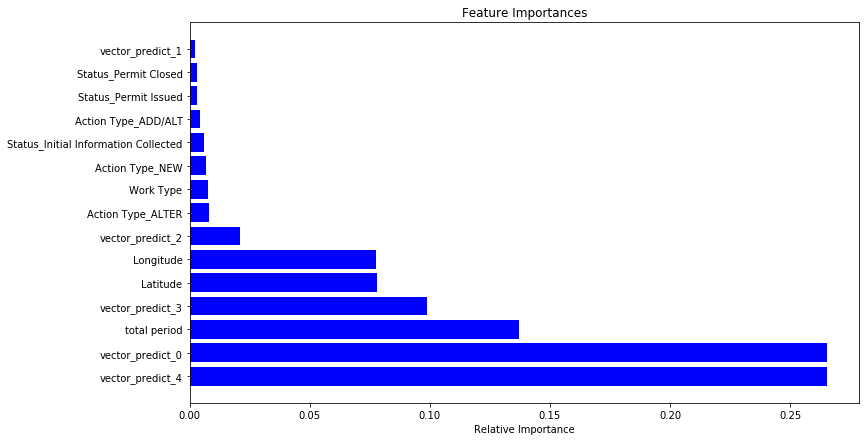

In [0]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
indices = indices[::-1][:15]
fig = plt.figure(figsize=(12, 7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('./feature_imp')

### Evaluation Metrics
#### Since it is an imbalanced Data Set, we can evaluate performance by computing precision, recall and F1-score

In [0]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score, precision_recall_curve
%matplotlib inline

In [0]:
predictions = rf.predict(X_validate)
conf_matrix = confusion_matrix(y_validate,predictions)
print(conf_matrix)

[[ 930    0    1   10   37]
 [  18   17    2    0    2]
 [  27    0   59    3    4]
 [  20    0    0  336   54]
 [   5    0    1   14 1814]]


In [0]:
print(classification_report(y_validate, predictions, target_names = list(le_name_mapping.keys())))

                        precision    recall  f1-score   support

            COMMERCIAL       0.93      0.95      0.94       978
            INDUSTRIAL       1.00      0.44      0.61        39
         INSTITUTIONAL       0.94      0.63      0.76        93
           MULTIFAMILY       0.93      0.82      0.87       410
SINGLE FAMILY / DUPLEX       0.95      0.99      0.97      1834

              accuracy                           0.94      3354
             macro avg       0.95      0.77      0.83      3354
          weighted avg       0.94      0.94      0.94      3354



#### Using predictions from Xgboost

In [0]:
predictions = rf.predict(X_validate)
conf_matrix = confusion_matrix(y_validate,predictions)

print(conf_matrix)

[[ 913    6   11   23   25]
 [  13   26    0    0    0]
 [  20    0   68    1    4]
 [  28    0    0  335   47]
 [  13    0    1   30 1790]]


In [0]:
list(le_name_mapping.keys())

['COMMERCIAL',
 'INDUSTRIAL',
 'INSTITUTIONAL',
 'MULTIFAMILY',
 'SINGLE FAMILY / DUPLEX']

In [0]:
print(classification_report(y_validate, predictions, target_names = list(le_name_mapping.keys())))

                        precision    recall  f1-score   support

            COMMERCIAL       0.93      0.93      0.93       978
            INDUSTRIAL       0.81      0.67      0.73        39
         INSTITUTIONAL       0.85      0.73      0.79        93
           MULTIFAMILY       0.86      0.82      0.84       410
SINGLE FAMILY / DUPLEX       0.96      0.98      0.97      1834

              accuracy                           0.93      3354
             macro avg       0.88      0.82      0.85      3354
          weighted avg       0.93      0.93      0.93      3354



## Predict for Test Data

In [0]:
#splitting test data from cleaned train_test dataframe
test_df = train_test[df.shape[0]:]

In [0]:
test_application_number = test_df['Application/Permit Number']
test_df = test_df.drop(['Application/Permit Number'], axis = 1)


In [0]:
test_df['Latitude'].fillna((test_df['Latitude'].mean()), inplace=True)
test_df['Longitude'].fillna((test_df['Longitude'].mean()), inplace=True)

#### Encode the test Address data into vector using previously trained Address vectorizer

In [0]:
test_df['Address'] = test_df['Address'].astype(str)
test_df['Address'] = test_df['Address'].apply(modify_address)

In [0]:
test_addr_vector = addr_vectorizer.transform(test_df['Address'].tolist())  
test_addr_vector.shape

(22360, 1126)

#### encode test Description data using previously trained Description vectorizer

In [0]:
test_desc_vector = desc_vectorizer.transform(test_df['Description'].tolist())  
test_desc_vector.shape

(22360, 2631)

#### encode test Contractor data using previously trained Contractor vectorizer

In [0]:
test_contract_vector = contract_vectorizer.transform(test_df['Contractor'].tolist())  
test_contract_vector.shape

(22360, 1118)

In [0]:
test_vectors = scipy.sparse.hstack((test_addr_vector, test_desc_vector, test_contract_vector))
test_vectors

<22360x4875 sparse matrix of type '<class 'numpy.int64'>'
	with 303189 stored elements in COOrdinate format>

In [0]:
test_vector_predict = rf_vectors.predict(test_vectors)
test_vector_predict = test_vector_predict.reshape(-1, 1)
print("vector predict shape: {}".format(test_vector_predict.shape))

vector predict shape: (22360, 1)


In [0]:
test_df['vector_predict'] = test_vector_predict
test_df['vector_predict'] = test_df['vector_predict'].astype(str)
test_df = pd.get_dummies(test_df, columns = ['vector_predict'])

In [0]:
test_df.drop(['Contractor', 'Address', 'Description'], axis = 1, inplace=True)

In [0]:
test_df['total period'] = (test_df['Expiration Date'] - test_df['Application Date']).dt.days
test_df['total period'].fillna(diff.mean(), inplace = True) 
test_df = test_df.drop(['Expiration Date','Application Date'] , axis = 1)


In [0]:
print(test_df.shape)
test_df.head()

(22360, 42)


,Work Type,Latitude,Longitude,Permit Type_Construction,Permit Type_Demolition,Permit Type_Site Development,Action Type_ADD/ALT,Action Type_ALTER,Action Type_CURB CUT,Action Type_DECONSTRUCTION,Action Type_DEMOLITION,Action Type_DRAINAGE APPROVAL,Action Type_FLOODPLAIN LICENSE ONLY,Action Type_GRADING,Action Type_NA,Action Type_NEW,Action Type_NO CONSTRUCTION,Action Type_RELOCATION,Action Type_SHORELINE EXEMPTION ONLY,Action Type_SITE MONITORING ONLY,Action Type_TEMP,Action Type_TREE PROTECTION EXEMPTION,Action Type_TREE/VEGETATION MAINT/RESTORE,Status_AP Closed,Status_AP Finaled,Status_Application Accepted,Status_CANCELLED,Status_Cert of Occupancy Authorized,Status_Information Collected,Status_Initial Information Collected,Status_Inspections Added,Status_NA,Status_Permit Closed,Status_Permit Finaled,Status_Permit Issued,Status_Reviews Completed,vector_predict_0,vector_predict_1,vector_predict_2,vector_predict_3,vector_predict_4,total period
0,0,47.690123,-122.379795,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,549.000000
1,0,47.540111,-122.290535,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,547.000000
2,0,47.540470,-122.281410,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,694.400934
3,1,47.654986,-122.327467,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,795.000000
4,0,47.666714,-122.383900,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,549.000000


### predict Categories for Test Data

#### We do below step to avoid train and test feature order mismatch

In [0]:
test_df  = test_df[df.columns]

#### predict output categories (These are encoded values)

In [0]:
test_category = rf.predict(test_df)

#### Decode the above output to get Categories

In [0]:
test_category = le.inverse_transform(test_category)

#### create submission Dataframe and save

In [0]:
submission = pd.DataFrame({'Application/Permit Number': test_application_number, 'Category': test_category})

In [0]:
submission.shape

(22360, 2)

In [0]:
submission.head()

,Application/Permit Number,Category
0,6425384,SINGLE FAMILY / DUPLEX
1,6496502,SINGLE FAMILY / DUPLEX
2,6622347,INSTITUTIONAL
3,6565685,MULTIFAMILY
4,6487370,COMMERCIAL


In [0]:
submission.to_csv('./submission_modified.csv', sep = ',', index = False) 

In [0]:
files.download('submission_modified.csv')

In [0]:
files.download('category.png')

In [0]:

files.download('./feature_imp.png')